**기본 세팅**

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rc('font', family='NanumGothic') # 폰트 설정
mpl.rc('axes', unicode_minus=False) # 유니코드에서 음수 부호 설정

# 차트 스타일 설정
sns.set(font="NanumGothic", rc={"axes.unicode_minus":False}, style='darkgrid')
plt.rc("figure", figsize=(10,8))

warnings.filterwarnings("ignore")

---

# 6. 문서 유사도

## 6.1 문서 유사도 이해하기

문서 간의 유사도 비교는 일반적으로 코사인 유사도를 사용한다.

코사인 유사도는 벡터와 벡터 간의 유사도를 비교할 때 벡터의 크기보다는 상호 방향성이 얼마나 유사한지에 기반한다.

두 벡터 A와 B의 내적 값은 다음과 같이 표현 가능하다.

$$A\cdot B = \|A\|\|B\|\cos\theta$$

따라서 유사도 $\cos\theta$는 다음과 같다.

$$\text{Similarity} = \cos\theta = \dfrac{A\cdot B}{\|A\|\|B\|} = \dfrac{\sum_{i}^n A_{i}B_{i}}{\sqrt{\sum_{i}^n A_{i}^2}\sqrt{\sum_{i}^n B_{i}^2}}$$

간단한 문서에 대해 코사인 유사도를 구해보자.

In [3]:
# 두 벡터의 코사인 유사도
def cos_similarity(v1, v2):
    dot_product = v1 @ v2
    ab_norm = np.sqrt(sum(np.square(v1))) * np.sqrt(sum(np.square(v2)))
    similarity = dot_product / ab_norm
    
    return similarity

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

doc_list = ['if you take the blue pill, the story ends' ,
            'if you take the red pill, you stay in Wonderland',
            'if you take the red pill, I show you how deep the rabbit hole goes']

tfidf_vect = TfidfVectorizer()
feature_vect = tfidf_vect.fit_transform(doc_list)

print(feature_vect.shape)

(3, 18)


- 3개의 간단한 문서를 TF-IDF 피처 벡터화하였다.


- 각 문서별로 18개의 word 피처를 가지고 있다.

In [5]:
# Sparse Matrix형태를 Dense Matrix로 변환
feature_vect_dense = feature_vect.todense() # toarray()도 가능

# 첫 번째, 두 번째 문서 피처 벡터 추출
vect1 = np.array(feature_vect_dense[0]).reshape(-1,)
vect2 = np.array(feature_vect_dense[1]).reshape(-1,)

# 코사인 유사도 
similarity_simple = cos_similarity(vect1, vect2 )
print(f"문서 1, 문서 2 Cosine 유사도: {similarity_simple:.3f}")

문서 1, 문서 2 Cosine 유사도: 0.402


- 문서 1과 문서 2의 코사인 유사도는 0.402로 나타난다.


- 다른 문서끼리도 같은 방법으로 코사인 유도를 구할 수 있다.


- 이번엔 이를 보다 편하게 구할 수 있는 사이킷런 패키지를 사용해보자.

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_simple_pair = cosine_similarity(feature_vect[0] , feature_vect[1:])
print(similarity_simple_pair)

[[0.40207758 0.40425045]]


- `sklearn.metrics.pairwise`의 `cosine_similarity()`를 이용하여 코사인 유사도를 구할 수 있다.


- 인수로는 희소 행렬, 밀집 행렬, 배열 등 모두 가능하여 따로 변환이 필요없다.


- 문서 1과 문서 2, 문서 1과 문서 3의 유사도를 구하였다.

In [7]:
similarity_simple_pair = cosine_similarity(feature_vect , feature_vect)
print(similarity_simple_pair)

[[1.         0.40207758 0.40425045]
 [0.40207758 1.         0.45647296]
 [0.40425045 0.45647296 1.        ]]


- 상관관계 행렬처럼 모든 문서의 쌍(pair)로 코사인 유사도를 구할 수 있다.

## 6.2 Opinion Review 실습

Opinion Review 데이터로 문서 유사도를 구해보자.

데이터, 데이터 불러오기, 피처 벡터화, K-Means는 모두 이전 포스팅 [문서 군집화](https://romg2.github.io/mlguide/03_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C-08.-%ED%85%8D%EC%8A%A4%ED%8A%B8%EB%B6%84%EC%84%9D-%EB%AC%B8%EC%84%9C-%EA%B5%B0%EC%A7%91%ED%99%94/)와 동일하다.

### 6.2.1 데이터 불러오기

In [8]:
import glob, os

# 경로 지정 (r string으로 탈출문자 그대로 인식)
path = r'C:\Users\ekzm3\Desktop\Github_kkd\Python_Study_ML\08.텍스트분석\OpinosisDataset1.0\topics'

# path에 존재하는 .data 파일들의 파일명을 리스트로 취합
all_files = glob.glob(os.path.join(path, "*.data"))

filename_list = []
opinion_text = []

for file in all_files:
    # 경로 등 제거 후 순수 파일명만 저장
    filename_ = file.split('\\')[-1]
    filename = filename_.split('.')[0]
    filename_list.append(filename)
    
    # 각 파일 데이터 프레임으로 생성 후 to_string으로 text화
    df = pd.read_table(file, index_col=None, header=0, encoding='latin1')
    opiniontext = df.to_string().replace("   ", "") # 첫 공백 제거
    opinion_text.append(opiniontext)
    
# 파일명, 파일내용을 데이터 프레임으로 생성
document_df = pd.DataFrame({'filename':filename_list, 'opinion_text':opinion_text})

### 6.2.2 피처 벡터화

**tokenizer 함수**

In [9]:
from nltk.stem import WordNetLemmatizer
import nltk
import string

# 단어 원형 추출 함수
lemmar = WordNetLemmatizer()
def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

# 특수 문자 사전 생성: {33: None ...}
# ord(): 아스키 코드 생성
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)

# 특수 문자 제거 및 단어 원형 추출
def LemNormalize(text):
    # 텍스트 소문자 변경 후 특수 문자 제거
    text_new = text.lower().translate(remove_punct_dict)
    
    # 단어 토큰화
    word_tokens = nltk.word_tokenize(text_new)
    
    # 단어 원형 추출
    return LemTokens(word_tokens)

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(stop_words='english' , ngram_range=(1,2), 
                             tokenizer = LemNormalize, min_df=0.05, max_df=0.85)

# 피처 벡터화: TF-IDF
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

### 6.2.3 K-Means(3)

In [11]:
from sklearn.cluster import KMeans

# KMeans: 3
km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)

# cluster 및 중심 좌표 정보
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

# cluster 라벨 추가
document_df['cluster_label'] = cluster_label
document_df.head()

,filename,opinion_text,cluster_label
0,accuracy_garmin_nuvi_255W_gps,", and is very, very accurate .\n0but for the m...",0
1,bathroom_bestwestern_hotel_sfo,"The room was not overly big, but clean and ve...",1
2,battery-life_amazon_kindle,After I plugged it in to my USB hub on my com...,0
3,battery-life_ipod_nano_8gb,short battery life I moved up from an 8gb ....,0
4,battery-life_netbook_1005ha,"6GHz 533FSB cpu, glossy display, 3, Cell 23Wh...",0


### 6.2.4 문서 유사도

In [12]:
from sklearn.metrics.pairwise import cosine_similarity

# cluster_label=1(호텔)인 인덱스
hotel_indexes = document_df[document_df['cluster_label']==1].index

# 호텔 군집 중 첫 번째 문서 파일명
comparison_docname = document_df.iloc[hotel_indexes[0]]["filename"]
print("호텔 군집 첫 문서:", comparison_docname)

# 호텔 군집 첫 번째 문서와 호텔 군집 문서 전체간의 코사인 유사도
similarity_pair = cosine_similarity(feature_vect[hotel_indexes[0]] , feature_vect[hotel_indexes])
print(similarity_pair)

호텔 군집 첫 문서: bathroom_bestwestern_hotel_sfo
[[1.         0.04419259 0.05058336 0.0646409  0.05989081 0.06286964
  0.03761874 0.1206444  0.38005031 0.32437906 0.51782913 0.11250381
  0.1385535  0.13647283 0.09744676 0.07216368]]


- 군집 1은 호텔에 대한 리뷰로 군집화되어 있다.


- index를 활용해 호텔 군집 첫 번째 문서, 호텔 군집 문서 전체의 코사인 유사도를 확인하였다.


- 이를 조금 더 직관적으로 보기 위해 시각화 해보자.

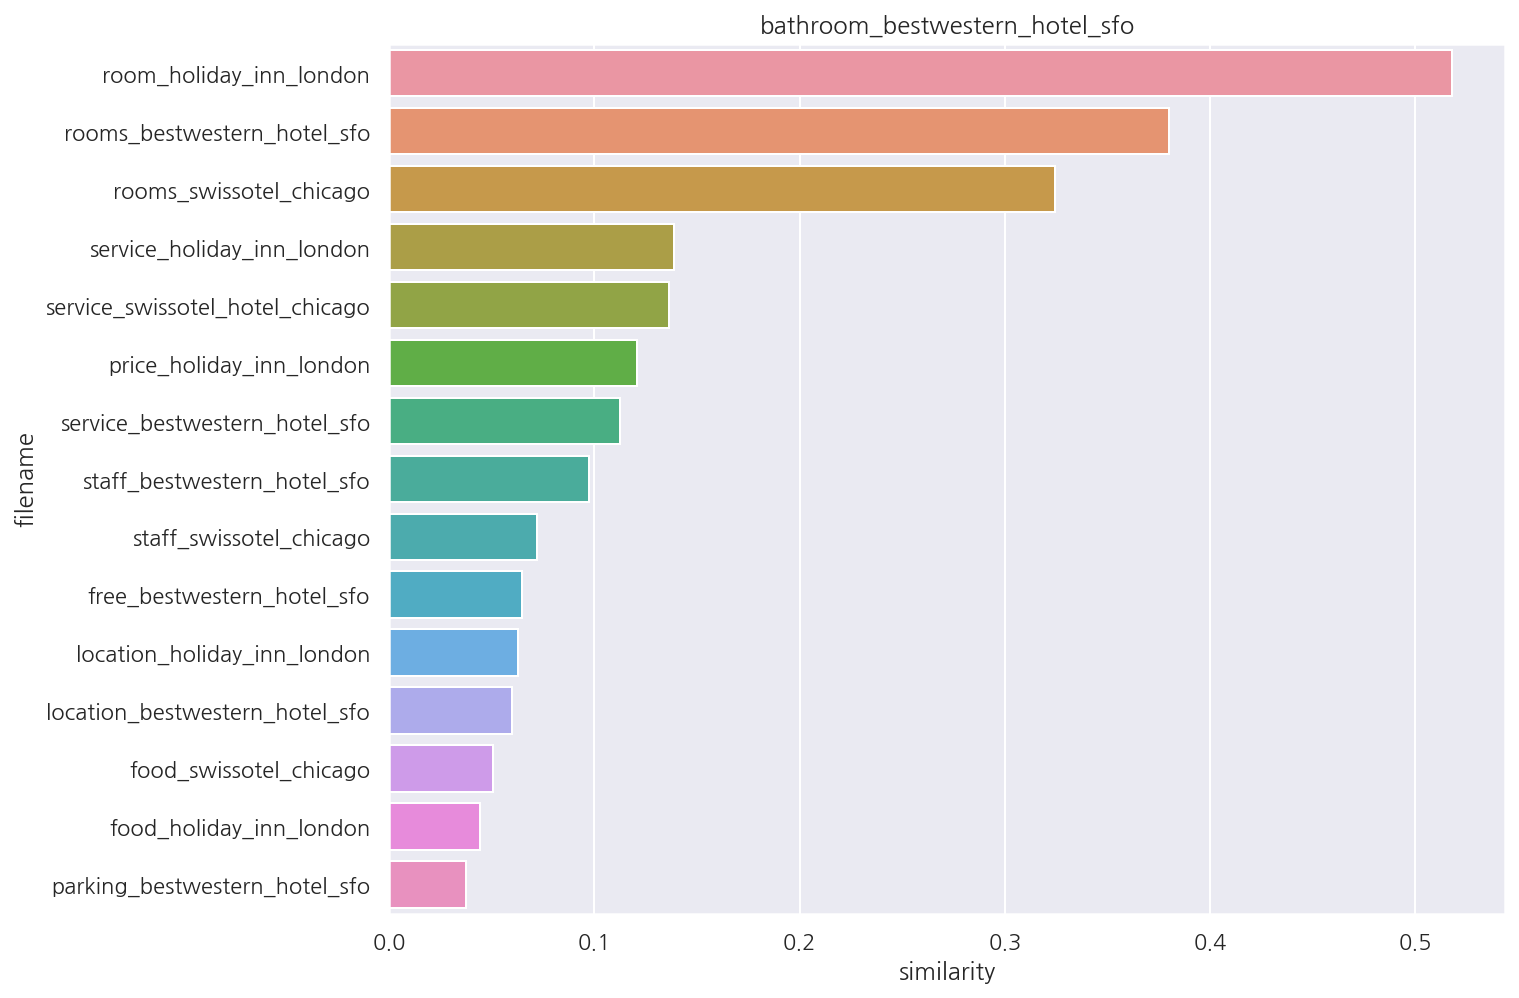

In [13]:
# 호텔 군집 문서 파일명 데이터 프레임
hotel = document_df.iloc[hotel_indexes][["filename"]].reset_index(drop=True)

# 코사인 유사도 추가
hotel["similarity"] = similarity_pair.reshape(-1,1)

# 첫 번째 문서 제외 후 내림차순 정렬
hotel_fin = hotel.iloc[1:].sort_values(by="similarity", ascending=False)

# 시각화
sns.barplot(x="similarity", y="filename", data=hotel_fin)
plt.title(comparison_docname)
plt.show()

- 첫 번째 문서가 어떤 문서와 유사한지 보다 편하게 확인 가능하다.


- 교재 코드가 복잡해서 간략하게 수정하였다.